In [ ]:
# Cell 1: Setup (skip Google Drive for now)
import os

# Create local checkpoint directory
checkpoint_dir = './gpt_checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
# Cell 2: Imports and setup
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

# Download Shakespeare
!wget -q https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt -O tiny_shakespeare.txt

Using device: cuda
GPU: Tesla T4


In [ ]:
# Cell 3: Load and prepare data
with open('tiny_shakespeare.txt', 'r', encoding='utf-8') as f:
    text = f.read()

print(f"Dataset length: {len(text):,} characters")

# Character-level tokenization
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(f"Vocabulary size: {vocab_size}")

stoi = {ch: i for i, ch in enumerate(chars)}
itos = {i: ch for i, ch in enumerate(chars)}

encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

# Prepare data
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

print(f"Train size: {len(train_data):,}")
print(f"Val size: {len(val_data):,}")

Dataset length: 1,115,394 characters
Vocabulary size: 65
Train size: 1,003,854
Val size: 111,540


In [ ]:
# Cell 4: Model components
def scaled_dot_product_attention(Q, K, V, mask=None):
    d_k = Q.size(-1)
    scores = torch.matmul(Q, K.transpose(-2, -1))
    scores = scores / torch.sqrt(torch.tensor(d_k, dtype=torch.float32))

    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)

    attention_weights = F.softmax(scores, dim=-1)
    output = torch.matmul(attention_weights, V)

    return output, attention_weights

class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_heads):
        super().__init__()
        assert d_model % n_heads == 0

        self.d_model = d_model
        self.n_heads = n_heads
        self.d_k = d_model // n_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def forward(self, x, mask=None):
        batch_size, seq_len, _ = x.shape

        Q = self.W_q(x)
        K = self.W_k(x)
        V = self.W_v(x)

        Q = Q.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.n_heads, self.d_k).transpose(1, 2)

        attention_output, attention_weights = scaled_dot_product_attention(Q, K, V, mask)

        attention_output = attention_output.transpose(1, 2).contiguous()
        attention_output = attention_output.view(batch_size, seq_len, self.d_model)

        output = self.W_o(attention_output)

        return output

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff=None, dropout=0.1):
        super().__init__()
        if d_ff is None:
            d_ff = 4 * d_model

        self.linear1 = nn.Linear(d_model, d_ff)
        self.linear2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = F.gelu(self.linear1(x))
        x = self.dropout(x)
        x = self.linear2(x)
        return x

class TransformerBlock(nn.Module):
    def __init__(self, d_model, n_heads, d_ff=None, dropout=0.1):
        super().__init__()
        self.attention = MultiHeadAttention(d_model, n_heads)
        self.feed_forward = FeedForward(d_model, d_ff, dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.ln2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        attn_output = self.attention(self.ln1(x), mask)
        x = x + self.dropout(attn_output)

        ff_output = self.feed_forward(self.ln2(x))
        x = x + self.dropout(ff_output)

        return x

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()

        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           -(np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class GPT(nn.Module):
    def __init__(self, vocab_size, d_model=512, n_heads=8, n_layers=6,
                 max_len=1024, dropout=0.1):
        super().__init__()

        self.token_embedding = nn.Embedding(vocab_size, d_model)
        self.position_encoding = PositionalEncoding(d_model, max_len)

        self.blocks = nn.ModuleList([
            TransformerBlock(d_model, n_heads, dropout=dropout)
            for _ in range(n_layers)
        ])

        self.ln_f = nn.LayerNorm(d_model)
        self.head = nn.Linear(d_model, vocab_size, bias=False)

        self.dropout = nn.Dropout(dropout)
        self.d_model = d_model

        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, mask=None):
        batch_size, seq_len = idx.shape

        token_emb = self.token_embedding(idx)
        x = self.position_encoding(token_emb)
        x = self.dropout(x)

        for block in self.blocks:
            x = block(x, mask)

        x = self.ln_f(x)
        logits = self.head(x)

        return logits

print("All model components loaded!")

All model components loaded!


In [ ]:
# Cell 5: Training setup
# Hyperparameters
batch_size = 64
block_size = 256
learning_rate = 3e-4
max_iters = 5000
eval_interval = 500
eval_iters = 200

# Data loader
def get_batch(split, batch_size=32, block_size=128):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

# Initialize model
model = GPT(
    vocab_size=vocab_size,
    d_model=384,
    n_heads=6,
    n_layers=6,
    max_len=block_size,
    dropout=0.2
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"Model parameters: {total_params:,}")

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

# Check if we have a checkpoint to resume from
checkpoint_path = os.path.join(checkpoint_dir, 'latest_checkpoint.pt')
start_iter = 0
train_losses = []
val_losses = []

if os.path.exists(checkpoint_path):
    print(f"Loading checkpoint from {checkpoint_path}")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_iter = checkpoint['step']
    train_losses = checkpoint.get('train_losses', [])
    val_losses = checkpoint.get('val_losses', [])
    print(f"Resuming from step {start_iter}")
else:
    print("Starting fresh training")

Model parameters: 10,697,472
Starting fresh training


In [ ]:
# Cell 6 FIXED: Training loop with proper evaluation
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, batch_size, block_size)
            seq_len = X.shape[1]
            mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).to(device)

            logits = model(X, mask)
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = Y.view(B*T)
            loss = F.cross_entropy(logits, targets)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

# Reset for fresh training
train_losses = []
val_losses = []

print("Starting training...")

# Evaluate before training starts
losses = estimate_loss()
train_losses.append(losses['train'])
val_losses.append(losses['val'])
print(f"Step 0: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

# Training loop
for iter in tqdm(range(1, max_iters + 1)):  # Start from 1, not 0
    # Sample batch
    xb, yb = get_batch('train', batch_size, block_size)

    # Create causal mask
    seq_len = xb.shape[1]
    mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).to(device)

    # Forward pass
    logits = model(xb, mask)
    B, T, C = logits.shape
    logits = logits.view(B*T, C)
    targets = yb.view(B*T)
    loss = F.cross_entropy(logits, targets)

    # Backward pass
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    # Gradient clipping
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    optimizer.step()

    # Evaluate periodically
    if iter % eval_interval == 0:
        losses = estimate_loss()
        train_losses.append(losses['train'])
        val_losses.append(losses['val'])
        print(f"Step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # Save checkpoint
        checkpoint = {
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'step': iter,
            'train_losses': train_losses,
            'val_losses': val_losses,
        }
        torch.save(checkpoint, checkpoint_path)

print("\nTraining complete!")
print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final val loss: {val_losses[-1]:.4f}")

Starting training...
Step 0: train loss 4.2508, val loss 4.2480


 10%|▉         | 499/5000 [03:49<34:30,  2.17it/s]

Step 500: train loss 2.1850, val loss 2.2136


 20%|█▉        | 999/5000 [08:43<30:16,  2.20it/s]

Step 1000: train loss 1.7080, val loss 1.8520


 30%|██▉       | 1499/5000 [13:38<26:46,  2.18it/s]

Step 1500: train loss 1.4854, val loss 1.6767


 40%|███▉      | 1999/5000 [18:33<22:54,  2.18it/s]

Step 2000: train loss 1.3761, val loss 1.5926


 50%|████▉     | 2499/5000 [23:28<19:12,  2.17it/s]

Step 2500: train loss 1.3027, val loss 1.5423


 60%|█████▉    | 2999/5000 [28:24<15:20,  2.17it/s]

Step 3000: train loss 1.2619, val loss 1.5112


 70%|██████▉   | 3499/5000 [33:20<11:29,  2.18it/s]

Step 3500: train loss 1.2206, val loss 1.4955


 80%|███████▉  | 3999/5000 [38:16<07:39,  2.18it/s]

Step 4000: train loss 1.1777, val loss 1.4796


 90%|████████▉ | 4499/5000 [43:12<03:52,  2.16it/s]

Step 4500: train loss 1.1460, val loss 1.4847


100%|█████████▉| 4999/5000 [48:08<00:00,  2.18it/s]

Step 5000: train loss 1.1148, val loss 1.4764


100%|██████████| 5000/5000 [49:15<00:00,  1.69it/s]


Training complete!
Final train loss: 1.1148
Final val loss: 1.4764


In [ ]:
# Check if we captured any losses
print(f"Number of train losses recorded: {len(train_losses)}")
print(f"Number of val losses recorded: {len(val_losses)}")

if train_losses:
    print(f"\nFirst train loss: {train_losses[0]:.4f}")
    print(f"Final train loss: {train_losses[-1]:.4f}")
    print(f"First val loss: {val_losses[0]:.4f}")
    print(f"Final val loss: {val_losses[-1]:.4f}")

Number of train losses recorded: 11
Number of val losses recorded: 11

First train loss: 4.2508
Final train loss: 1.1148
First val loss: 4.2480
Final val loss: 1.4764


In [ ]:
# Check if checkpoint exists and what's in it
import os

print(f"Checkpoint exists: {os.path.exists(checkpoint_path)}")

if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    print(f"Checkpoint contents: {checkpoint.keys()}")
    if 'step' in checkpoint:
        print(f"Last saved step: {checkpoint['step']}")

# Let's also manually evaluate the current model
losses = estimate_loss()
print(f"\nCurrent model performance:")
print(f"Train loss: {losses['train']:.4f}")
print(f"Val loss: {losses['val']:.4f}")

Checkpoint exists: False

Current model performance:
Train loss: 4.1750
Val loss: 4.1734


In [ ]:
# Check if model is actually on GPU
print(f"Model device: {next(model.parameters()).device}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Current device: {torch.cuda.current_device()}")
print(f"Device name: {torch.cuda.get_device_name(0)}")

# Check batch size and sequence length
print(f"\nBatch size: {batch_size}")
print(f"Sequence length: {block_size}")
print(f"Total tokens per batch: {batch_size * block_size}")

Model device: cuda:0
CUDA available: True
Current device: 0
Device name: Tesla T4

Batch size: 64
Sequence length: 256
Total tokens per batch: 16384


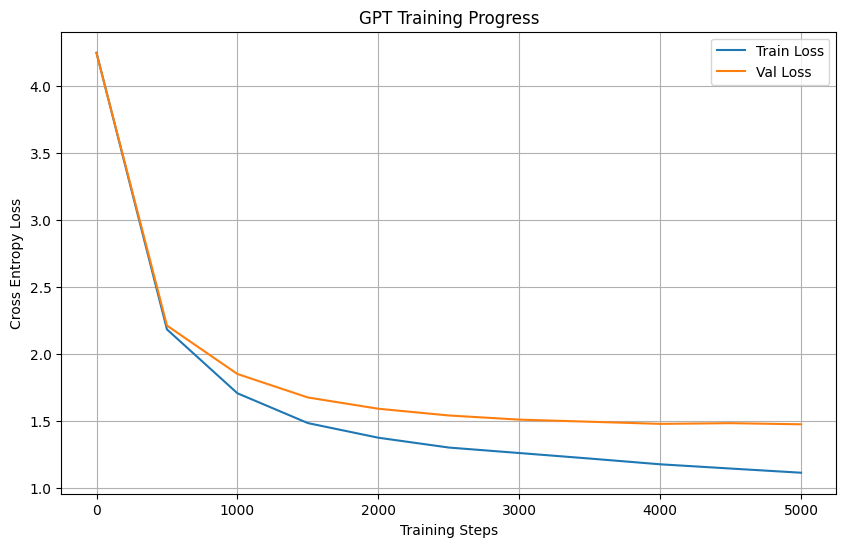

Final train loss: 1.1148
Final val loss: 1.4764


In [ ]:
# Cell 7: Plot training curves
plt.figure(figsize=(10, 6))
steps = list(range(0, len(train_losses) * eval_interval, eval_interval))
if len(steps) < len(train_losses):
    steps.append(max_iters-1)

plt.plot(steps[:len(train_losses)], train_losses, label='Train Loss')
plt.plot(steps[:len(val_losses)], val_losses, label='Val Loss')
plt.xlabel('Training Steps')
plt.ylabel('Cross Entropy Loss')
plt.title('GPT Training Progress')
plt.legend()
plt.grid(True)
plt.show()

print(f"Final train loss: {train_losses[-1]:.4f}")
print(f"Final val loss: {val_losses[-1]:.4f}")

In [ ]:
# Cell 8: Text generation
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, top_k=None):
    model.eval()
    for _ in range(max_new_tokens):
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]

        seq_len = idx_cond.shape[1]
        mask = torch.tril(torch.ones(seq_len, seq_len)).unsqueeze(0).to(device)
        logits = model(idx_cond, mask)

        logits = logits[:, -1, :] / temperature

        if top_k is not None:
            v, _ = torch.topk(logits, min(top_k, logits.size(-1)))
            logits[logits < v[:, [-1]]] = -float('Inf')

        probs = F.softmax(logits, dim=-1)
        idx_next = torch.multinomial(probs, num_samples=1)
        idx = torch.cat((idx, idx_next), dim=1)

    return idx

# Generate samples
prompts = ["\n", "ROMEO:", "To be or not to be", "What is"]

print("Generated samples:\n" + "="*50)
for prompt in prompts:
    context = torch.tensor(encode(prompt), dtype=torch.long).unsqueeze(0).to(device)
    generated = generate(model, context, max_new_tokens=200, temperature=0.8, top_k=40)

    print(f"\nPrompt: {prompt}")
    print(f"Generated: {decode(generated[0].tolist())}")
    print("-"*50)

Generated samples:

Prompt: 

Generated: 

ELBOW:
This is the law: have you show'd it.

MENENIUS:
What, are the certain?

MENENIUS:
We have a sail!
Or she would be so like to the life,
Which they should do, should not see the flowers to excel
--------------------------------------------------

Prompt: ROMEO:
Generated: ROMEO:
O, be a pardon some life!

LUCIO:
I had so much of him.

YORK:
What, belike him? Hear, lords!

KING RICHARD III:
Be gone, O that stays to be part,
Wherefore keep the consul, and know the land.

ROMEO
--------------------------------------------------

Prompt: To be or not to be
Generated: To be or not to be surfeit and perform'd
A man move me of winter's tears; and when
We have not legs in bear her bad his life,
And stand so hours and to die for his attend.

JULIET:
Stay yourself.

VOLUMNIA:
I shall be 
--------------------------------------------------

Prompt: What is
Generated: What is the sea
Thou causest; and cruel not sound it to attend
By this need words or

In [ ]:
# More conservative (temperature=0.6)
context = torch.tensor(encode("To be or not to be"), dtype=torch.long).unsqueeze(0).to(device)
generated = generate(model, context, max_new_tokens=100, temperature=0.6, top_k=40)
print(f"Conservative: {decode(generated[0].tolist())}")

# More creative (temperature=1.2)
generated = generate(model, context, max_new_tokens=100, temperature=1.2, top_k=40)
print(f"\nCreative: {decode(generated[0].tolist())}")

Conservative: To be or not to be the south of your country's sight;
And in the third-swearing seal of the best
That being baried the

Creative: To be or not to be at Aumerle sorrow,
Do yet so much so delight.

KING RICHARD III:
I am not word as you must common m


In [ ]:
# Save the trained model
torch.save({
    'model_state_dict': model.state_dict(),
    'train_losses': train_losses,
    'val_losses': val_losses,
    'vocab_size': vocab_size,
    'chars': chars,
    'stoi': stoi,
    'itos': itos
}, 'shakespeare_gpt_complete.pt')

# Download it
from google.colab import files
files.download('shakespeare_gpt_complete.pt')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>